# FRIENDS Datasets Analysis, Parsing, and Preprocessing

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

In [2]:
# script and IMDB ratings imports
df_script = pd.read_csv("friends_all_episodes_clean.csv")
df_rating = pd.read_csv("friends_episodes_v3.csv", encoding='latin-1')

---

## Script Dataset Preprocessing

Checking per column what attributes are available or can be derived. Also checking what preprocessing is needed and implementing it. The dataset is from Kaggle, made by users Bree Nguyen and Blesson Densil, accessible [here](https://www.kaggle.com/datasets/brzy56/friends-tv-television-scripts-all-dialogue-csv).

The column names and descriptions are:
- `episode_number` — Episode code (e.g., `S01E01`)
- `title` — Episode title
- `writers` — Writer(s) of the episode
- `type` — Classification: dialogue, stage_direction, scene_note, content
- `speaker` — Character speaking (blank if not dialogue)
- `dialogue_raw` — Original dialogue text (includes inline notes)
- `dialogue_clean` — Dialogue text with inline notes removed
- `stage_direction_inline` — Inline parentheses content within dialogue
- `scene_note_inline` — Inline bracket content within dialogue
- `stage_direction_only` — For standalone stage direction lines
- `scene_note_only` — For standalone scene note lines
- `content` — Non‑dialogue text/content lines
- `season` — Season number
- `episode` — Episode number

In [3]:
df_script.head(5)

,episode_number,title,writers,type,speaker,dialogue_raw,dialogue_clean,stage_direction_inline,scene_note_inline,stage_direction_only,scene_note_only,content,season,episode
0,S01E01,The One Where Monica Gets a New Roommate (The ...,Marta Kauffman & David Crane,scene_note,NaN,NaN,NaN,NaN,NaN,NaN,"Scene: Central Perk, Chandler, Joey, Phoebe, a...",NaN,1.0,1.0
1,S01E01,The One Where Monica Gets a New Roommate (The ...,Marta Kauffman & David Crane,dialogue,Monica,There's nothing to tell! He's just some guy I ...,There's nothing to tell! He's just some guy I ...,NaN,NaN,NaN,NaN,NaN,1.0,1.0
2,S01E01,The One Where Monica Gets a New Roommate (The ...,Marta Kauffman & David Crane,dialogue,Joey,"C'mon, you're going out with the guy! There's ...","C'mon, you're going out with the guy! There's ...",NaN,NaN,NaN,NaN,NaN,1.0,1.0
3,S01E01,The One Where Monica Gets a New Roommate (The ...,Marta Kauffman & David Crane,dialogue,Chandler,"All right Joey, be nice. So does he have a hu...","All right Joey, be nice. So does he have a hu...",NaN,NaN,NaN,NaN,NaN,1.0,1.0
4,S01E01,The One Where Monica Gets a New Roommate (The ...,Marta Kauffman & David Crane,dialogue,Phoebe,"Wait, does he eat chalk?","Wait, does he eat chalk?",NaN,NaN,NaN,NaN,NaN,1.0,1.0


### "title" using `ratings` and "episode_number", "episode", and "season"

All episode titles start with "The One With / Where". Some values need preprocessing to add the full title or for formatting/typos. This preprocessing is possible using the `ratings` dataset. 

First, episodes split into parts need preprocessing. In `ratings` they are separate, but in `script` they appear together 9/10 times. First the episodes need to be split, then `episode_number`, `episode`, and `season` need to be calculated. `episode` and `season` can then be matched between the two datasets to clean the `script` dataset's column.

There is a short included in the episode called "Friends Special: The Stuff You've Never Seen". Since this is not a part of the series, it is removed from the dataset.

In [4]:
df_script = df_script[~(df_script["episode_number"] == "S07E24")]

There is a column called `episode_number` with the format SxxEyy, where xx is the `season` number and yy is the `episode` number. We impute these for an easier preprocessing experience.

In [5]:
# make everything upper case
df_script["episode_number"] = df_script["episode_number"].str.upper()

In [6]:
# impute missing "season" and "episode" values from "episode_number"
df_script["season"] = df_script['episode_number'].str.extract('S(\d{2})E(\d{2})', expand=True)[0]
df_script["episode"] = df_script['episode_number'].str.extract('S(\d{2})E(\d{2})', expand=True)[1]

In [7]:
# fix type of episode and season
df_script["episode"] = df_script["episode"].astype(int)
df_script["season"] = df_script["season"].astype(int)

In [8]:
df_script["title"].unique()[-10:]

array(['The Late Thanksgiving', 'The Birth Mother',
       'Chandler Gets Caught', 'The Stripper Cries', 'Phoebes Wedding',
       'Joey Speaks French', 'Princess Consuela', 'Estelle Dies',
       'Rachels Going Away Party', 'The Last One Part I  II'],
      dtype=object)

Some episodes have a Part 1 and a Part 2. Here, "episode" alone only shows the first episode's number and not the second's.  We could add a binary attribute which indicates when an episode is part of a Part 1 and Part 2.

There are 10 two-part episodes in FRIENDS, but the dataset only identifies 4 of them.

In [9]:
# Four entries in "episode_number" are Part 1 and Part 2 episodes
parts_list = []

for ep in df_script["episode_number"].unique():
    if "-" in  ep:
        print(ep)
        parts_list.append(ep)

S02E12-S02E13
S06E15-S06E16
S09E23-S09E24
S10E17-S10E18


In [10]:
# "episode" only shows the first episode and not the second in parts
# df_script[df_script["episode_number"] == "S02E12-S02E13"]
print(df_script[(df_script["episode_number"] == "S02E12-S02E13") & (df_script["episode"] == "13")].empty)
print(df_script[(df_script["episode_number"] == "S06E15-S06E16") & (df_script["episode"] == "16")].empty)
print(df_script[(df_script["episode_number"] == "S09E23-S09E24") & (df_script["episode"] == "24")].empty)
print(df_script[(df_script["episode_number"] == "S10E17-S10E18") & (df_script["episode"] == "18")].empty)

True
True
True
True


There need to be 236 episodes in the dataset, which matches with the `rating` dataset. There are currently less as a result of the non-splitting of two-part episodes.

- `The One With Two Parts` is split into 2 (S01E16, S01E17)

Episodes the dataset recognizes as two-part by way of SxxEyy-SxxEzz in the `episode_number`, but appear as one row:
- `The One After the Superbowl` (S02E12-S02E13)
- `The One That Could Have Been` (S06E15-S06E16)
-  `(The One) In Barbados` (S09E23-S09E24)
- `The Last One Part I  II` (S10E17-S10E18)

Episodes the dataset does not recognize as two-part and appear in one row:
- `The One With Ross’s Wedding Parts I and II` (S04E23)
- `The One In Vegas` (S05E23)
- `The One With The Proposal` (S06E24)
- `The One With Chandler and Monica’s Wedding` (S07E23)
- `The One Where Rachel Has A Baby` (S08E23)

The nine two-parts need to be split based on the `dialogue_clean` column.

In [11]:
# Manually found markers or split points
splits = [
    # cutoff, old_value, before_value, after_value
    (10165, "S02E12-S02E13", "S02E12", "S02E13"),
    (39393, "S06E15-S06E16", "S06E15", "S06E16"),
    (63849, "S09E23-S09E24", "S09E23", "S09E24"),
    (70016, "S10E17-S10E18", "S10E17", "S10E18"),

    # different label: single-episode splits (+1 for after)
    (27635, "S04E23", "S04E23", "S04E24"),
    (34793, "S05E23", "S05E23", "S05E24"),
    (42169, "S06E24", "S06E24", "S06E25"),
    (49274, "S07E23", "S07E23", "S07E24"),
    (56567, "S08E23", "S08E23", "S08E24"),
]

In [12]:
# creating a copy to not ruin the OG dataset
df = df_script.copy()
for cutoff, old_val, before_val, after_val in splits:
    df.loc[:cutoff, "episode_number"] = df.loc[:cutoff, "episode_number"].replace(old_val, before_val)
    df.loc[cutoff+1:, "episode_number"] = df.loc[cutoff+1:, "episode_number"].replace(old_val, after_val)

In [13]:
# REPEAT: impute missing "season" and "episode" values from "episode_number"
df["season"] = df['episode_number'].str.extract('S(\d{2})E(\d{2})', expand=True)[0]
df["episode"] = df['episode_number'].str.extract('S(\d{2})E(\d{2})', expand=True)[1]

In [14]:
# REPEAT: fix type of episode and season
df["episode"] = df["episode"].astype(int)
df["season"] = df["season"].astype(int)

In [15]:
df_script["episode_number"], df_script["episode"], df_script["season"] = df["episode_number"], df["episode"], df["season"]

In [16]:
# total number of episodes in the current dataset
len(df_script["episode_number"].unique())

236

Using the `ratings` dataset, it should now be possible to replace the misspelled and incorrectly formatted titles in the `script` dataset.

In [17]:
df_rating.tail(5)

,Year_of_prod,Season,Episode Number,Episode_Title,Duration,Summary,Director,Stars,Votes
231,2004,10,14,The One with Princess Consuela,22,When Phoebe goes to get her name changed she r...,Gary Halvorson,8.6,2989
232,2004,10,15,The One Where Estelle Dies,22,Ross tries to get Rachel to go back to Ralph L...,Gary Halvorson,8.5,2771
233,2004,10,16,The One with Rachel's Going Away Party,22,"The gang throws Rachel a goodbye party, during...",Gary Halvorson,8.9,3141
234,2004,10,17,The Last One: Part 1,30,Erica gives birth to the baby that Monica and ...,Kevin Bright,9.5,6221
235,2004,10,18,The Last One: Part 2,30,Phoebe races Ross to the airport in a bid to s...,Kevin Bright,9.7,10381


In [18]:
# copy df again for the merge
df1 = df_script.merge(
    df_rating[["Season", "Episode Number", "Episode_Title"]],
    left_on=["season", "episode"],
    right_on=["Season", "Episode Number"],
    how="left"
)

df1["title"] = df1["Episode_Title"]
df1 = df1.drop(columns=["Season", "Episode Number", "Episode_Title"])

In [19]:
# the "title" column has been replaced; add back to OG dataset
df_script = df1.copy()

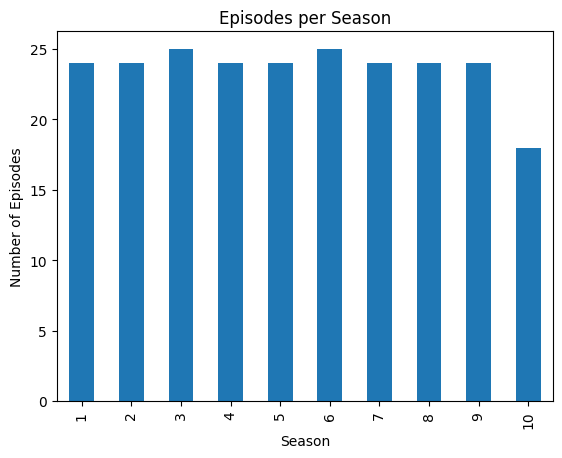

In [20]:
# number of episodes per season
ep_per_season = df_script.groupby("season")["episode"].max()

ep_per_season.plot(kind="bar")

plt.xlabel("Season")
plt.ylabel("Number of Episodes")
plt.title("Episodes per Season")
plt.show();

<div class="alert alert-block alert-info">
    This method fixed 4 columns at the same time, using an additional dataset to fix one of the columns. Splitting the two-part     episodes was also done manually using row indices, meaning these are not reliable values for later on, since rows are           removed based on certain contents.
</div>

### Interlude: get rid of "content" column and rows
Based on the column `type` for the rows and the column `content`. These contain commercial breaks, transcription notes, etc.

In [21]:
df_script["content"].unique()[:5]

array([nan, 'Commercial Break', 'Closing Credits', 'End',
       'Opening Credits'], dtype=object)

In [22]:
df_script[df_script["type"] == "content"][:5]

,episode_number,title,writers,type,speaker,dialogue_raw,dialogue_clean,stage_direction_inline,scene_note_inline,stage_direction_only,scene_note_only,content,season,episode
121,S01E01,The One Where Monica Gets a Roommate: The Pilot,Marta Kauffman & David Crane,content,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Commercial Break,1,1
189,S01E01,The One Where Monica Gets a Roommate: The Pilot,Marta Kauffman & David Crane,content,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Commercial Break,1,1
318,S01E01,The One Where Monica Gets a Roommate: The Pilot,Marta Kauffman & David Crane,content,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Closing Credits,1,1
338,S01E01,The One Where Monica Gets a Roommate: The Pilot,Marta Kauffman & David Crane,content,NaN,NaN,NaN,NaN,NaN,NaN,NaN,End,1,1
350,S01E02,The One with the Sonogram at the End,Marta Kauffman & David Crane,content,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Opening Credits,1,2


In [23]:
print("Before:", df_script.shape)

df_script = df_script.drop("content", axis='columns').copy()
df_script = df_script[df_script["type"] != "content"]

print("After:", df_script.shape)

Before: (70074, 14)
After: (68796, 13)


### "writers"

Writers sometimes had name changes (hyphenated surnames after marriage or new stage names). Along with these adjustments, misspellings were fixed. Missing writer names (for 81 episodes) were also filled in.

In total there were 50 writers, some only working on one episode. The preprocessing below changes each writers cell into a list with all the authors.

For the model, we may need to use `.explode()`.

In [24]:
print(df_script["writers"].dropna().unique().tolist())

['Marta Kauffman & David Crane', 'Jeffrey Astrof & Mike Sikowitz.', 'Alexa Junge', 'Jeff Greenstein & Jeff Strauss', 'Adam Chase & Ira Ungerleider', 'Jeffrey Astrof and Mike Sikowitz.', 'Marta Kaufmann & David Crane', 'Jeffrey Astrof, Mike Sikowitz, Adam Chase & Ira Ungerleider', 'Bill Lawrence', 'Jeffrey Astrof and Mike Sikowitz. .', 'Jeffrey Astrof & Mike Sikowitz', 'Doty Abrams', 'Adam Chase and Ira Ungerleider', 'Chris Brown', 'Jeff Astroff & Mike Sikowitz', 'Ira Ungerlieder.', 'Michael Curtis and Gregory S. Malins', 'Ira Ungerleider', 'Wil Calhoun', 'Scott Silveri & Shana Goldnerg-Meehan.', 'Seth Kurland', 'Adam Chase', 'Michael Borkow', 'Scott Silveri & Shana Goldberg-Meehan', 'Andrew Reich & Ted Cohen', 'Jill Condon & Any Toomin', 'Seth Kirkland', 'Michael Curtis & Gregory S. Malins', 'Scott Silveri', 'Jill Condon & Amy Toomin', 'Shana Goldberg-Meehan', 'Wil Calhoun & Scott Silveri', 'Michael Curtis', 'Perry Rein & Gigi McCreery', 'Greg Malins', 'Alicia Sky Varinaitis', 'Shana G

In [25]:
def clean_writers(name):
    if pd.isna(name) or name == "unknown yet" or name == "":
        return np.nan
    
    name = str(name).strip()
    
    # Replace " & " and " and " with commas
    name = re.sub(r"\s*(&|and)\s*", ",", name, flags=re.IGNORECASE)
    
    # Special case: protect ", Jr." from being split
    name = name.replace(", Jr.", "§Jr.§")
    
    # Remove unnecessary whitespace and ".." or trailing "."
    name = re.sub(r"\s*,\s*", ",", name)
    name = re.sub(r"\.+$", "", name)
    name = re.sub(r"\s*\.+\s*$", "", name)
    
    # Split into list and restore "Jr."
    parts = [n.strip() for n in name.split(",") if n.strip()]
    parts = [p.replace("§Jr.§", ", Jr.") for p in parts]

    return parts

In [26]:
# Dictionary mapping episode numbers to missing writers (74 episodes)
missing_writers_dict = {
    "S01E23": ["Marta Kauffman", "David Crane", "Jeff Greenstein", "Jeff Astrof"],
    "S02E03": ["Michael Curtis", "Greg Malins"],
    "S02E15": ["Michael Curtis", "Greg Malins"],
    "S02E19": ["Michael Curtis", "Greg Malins"],
    "S02E04": ["Alexa Junge"],
    "S02E14": ["Alexa Junge"],
    "S02E22": ["Alexa Junge"],
    "S02E05": ["Chris Brown"],
    "S02E06": ["Betsy Borns"],
    "S02E16": ["Betsy Borns"],
    "S02E07": ["Michael Borkow"],
    "S04E23": ["Michael Borkow"],
    "S04E24": ["Shana Goldberg-Meehan", "Scott Silveri"],
    "S02E08": ["Marta Kauffman", "David Crane"],
    "S02E09": ["Jeff Astrof", "Mike Sikowitz"],
    "S02E11": ["Doty Abrams"],
    "S02E12": ["Jeff Astrof", "Mike Sikowitz", "Michael Borkow"],
    "S02E13": ["Jeff Astrof", "Mike Sikowitz", "Michael Borkow"],
    "S02E17": ["Adam Chase"],
    "S02E18": ["Alexa Junge", "Michael Borkow"],
    "S02E20": ["Adam Chase", "Michael Curtis", "Greg Malins"],
    "S04E20": ["Adam Chase", "Michael Curtis", "Greg Malins"],
    "S02E21": ["Sebastian Jones", "Brian Buckner"],
    "S02E23": ["Brown Mandell"],
    "S02E24": ["Ira Ungerleider", "Brown Mandell"],
    "S03E24": ["Pang-Ni Landrum", "Mark J. Kunerth", "Shana Goldberg-Meehan", "Scott Silveri"],
    "S03E25": ["Pang-Ni Landrum", "Mark J. Kunerth", "Adam Chase"],
    "S04E15": ["Wil Calhoun", "Andrew Reich", "Ted Cohen"],
    "S04E16": ["Shana Goldberg-Meehan", "Scott Silveri", "Alicia Sky Varinaitis"],
    "S04E17": ["Richard Goodman", "Mark J. Kunerth"],
    "S04E18": ["Jill Condon", "Amy Toomin", "Andrew Reich", "Ted Cohen"],
    "S04E22": ["Michael Curtis", "Greg Malins", "Seth Kurland"],
    "S05E11": ["Suzie Villandry", "Brian Boyle"],
    "S05E13": ["Michael Curtis", "Seth Kurland"],
    "S05E16": ["Gigi McCreery", "Perry Rein", "Alicia Sky Varinaitis"],
    "S05E21": ["Greg Malins", "Scott Silveri"],
    "S05E22": ["Wil Calhoun", "Shana Goldberg-Meehan"],
    "S05E23": ["Andrew Reich", "Ted Cohen"],
    "S05E24": ["Greg Malins", "Scott Silveri"],
    "S06E11": ["Brian Boyle", "Zachary Rosenblatt"],
    "S06E12": ["Andrew Reich", "Ted Cohen", "Shana Goldberg-Meehan"],
    "S06E13": ["Seth Kurland", "Sherry Bilsing", "Ellen Plummer"],
    "S06E15": ["Adam Chase", "Greg Malins"],
    "S06E16": ["David Crane", "Marta Kauffman"],
    "S06E17": ["Adam Chase", "Zachary Rosenblatt"],
    "S06E19": ["Gigi McCreery", "Perry Rein", "Seth Kurland"],
    "S06E21": ["Scott Silveri", "David J. Lagana"],
    "S06E22": ["Brian Caldirola", "Sherry Bilsing", "Ellen Plummer"],
    "S06E24": ["Shana Goldberg-Meehan", "Scott Silveri"],
    "S06E25": ["Andrew Reich", "Ted Cohen"],
    "S07E01": ["Marta Kauffman", "David Crane", "Wil Calhoun"],
    "S07E05": ["Patty Lin", "Earl Davis"],
    "S07E13": ["Sebastian Jones", "Brian Buckner", "Sherry Bilsing", "Ellen Plummer"],
    "S07E14": ["Vanessa McCarthy", "Sherry Bilsing", "Ellen Plummer"],
    "S07E15": ["Andrew Reich", "Ted Cohen", "Sherry Bilsing", "Ellen Plummer"],
    "S07E16": ["Zachary Rosenblatt", "Sebastian Jones", "Brian Buckner"],
    "S07E17": ["Sebastian Jones", "Brian Buckner", "Andrew Reich", "Ted Cohen"],
    "S07E18": ["Brian Boyle", "Sherry Bilsing", "Ellen Plummer"],
    "S07E22": ["Sebastian Jones", "Brian Buckner", "Greg Malins"],
    "S07E23": ["Greg Malins"],
    "S07E24": ["Marta Kauffman", "David Crane"],
    "S08E10": ["Sebastian Jones", "Brian Buckner", "Robert Carlock"],
    "S08E17": ["Steven Rosenhaus", "R. Lee Fleming, Jr."],
    "S08E18": ["Mark J. Kunerth", "Peter Tibbals"],
    "S08E21": ["Sebastian Jones", "Brian Buckner", "Dana Klein Borkow"],
    "S08E23": ["Scott Silveri"],
    "S08E24": ["Marta Kauffman", "David Crane"],
    "S09E08": ["Shana Goldberg-Meehan"],
    "S09E09": ["Mark J. Kunerth"],
    "S09E11": ["Peter Tibbals", "Judd Rubin"],
    "S09E12": ["Sebastian Jones", "Brian Buckner", "Dana Klein Borkow"],
    "S09E15": ["Peter Tibbals"],
    "S09E16": ["Mark J. Kunerth"],
    "S09E17": ["Sebastian Jones", "Brian Buckner", "Robert Carlock"],
    "S09E18": ["Sebastian Jones", "Brian Buckner", "Sherry Bilsing", "Ellen Plummer"],
    "S09E19": ["Mark J. Kunerth", "Dana Klein Borkow"],
    "S09E20": ["Andrew Reich", "Ted Cohen", "Shana Goldberg-Meehan"],
    "S09E21": ["Scott Silveri", "Robert Carlock"],
    "S09E23": ["Scott Silveri", "Shana Goldberg-Meehan"],
    "S09E24": ["Marta Kauffman", "David Crane"],
    "S10E14": ["Robert Carlock", "Tracy Reilly"]
}

# Function that looks up the episode number
def missing_writers(name, number):
    return missing_writers_dict.get(number, name)

In [27]:
# Dictionary mapping wrong names to correct names (misspelling and stage names)
name_corrections = {
    "Jeffrey Astrof": "Jeff Astrof",
    "Jeff Astroff": "Jeff Astrof",
    "Marta Kaufmann": "Marta Kauffman",
    "Ira Ungerlieder": "Ira Ungerleider",
    "Shana Goldnerg-Meehan": "Shana Goldberg-Meehan",
    "Any Toomin": "Amy Toomin",
    "Sherry Bilsing-Graham": "Sherry Bilsing",
    "Sherry Bilding-Graham": "Sherry Bilsing",
    "Gigi McCreey": "Gigi McCreery",
    "Gregory S. Malins": "Greg Malins",
    "Zack Rosenblatt": "Zachary Rosenblatt",
    "Dana Klein": "Dana Klein Borkow",
    "Mark Kunerth": "Mark J. Kunerth",
    "Seth Kurl": "Seth Kurland",
    "Seth Kirkl": "Seth Kurland",
    "rew Reich": "Andrew Reich"
}

def name_correction(name, corrections):    
    for index, n in enumerate(name):
        if n in corrections:
            name[index] = corrections[n]
    return name

In [28]:
# clean stray punctuation and formatting
df2 = df_script.copy()
df2["writers"] = df2["writers"].apply(clean_writers)

In [29]:
# fill in missing writers rows
print("There are", len(set(df2[df2["writers"].isnull()]["episode_number"])), "episodes missing writers' names.")
df2['writers'] = df2.apply(lambda row: missing_writers(row['writers'], row['episode_number']), axis=1)

There are 81 episodes missing writers' names.


In [30]:
# correct writer name misspellings and stage names
df2["writers"] = df2["writers"].apply(lambda x: name_correction(x, name_corrections))

In [31]:
## For viewing all writers
# Flatten the lists in the column into rows
all_writers = df2["writers"].explode()

unique_writers = all_writers.dropna().unique()

print(unique_writers)
print("\nThere were", len(unique_writers), "writers for the FRIENDS series. IMDB states that there were 50 writers in total.")

['Marta Kauffman' 'David Crane' 'Jeff Astrof' 'Mike Sikowitz'
 'Alexa Junge' 'Jeff Greenstein' 'Jeff Strauss' 'Adam Chase'
 'Ira Ungerleider' 'Bill Lawrence' 'Doty Abrams' 'Chris Brown'
 'Michael Curtis' 'Greg Malins' 'Betsy Borns' 'Michael Borkow'
 'Sebastian Jones' 'Brian Buckner' 'Brown Mandell' 'Wil Calhoun'
 'Scott Silveri' 'Shana Goldberg-Meehan' 'Seth Kurland' 'Andrew Reich'
 'Ted Cohen' 'Pang-Ni Landrum' 'Mark J. Kunerth' 'Jill Condon'
 'Amy Toomin' 'Alicia Sky Varinaitis' 'Richard Goodman' 'Perry Rein'
 'Gigi McCreery' 'Suzie Villandry' 'Brian Boyle' 'Sherry Bilsing'
 'Ellen Plummer' 'Zachary Rosenblatt' 'David J. Lagana' 'Brian Caldirola'
 'Patty Lin' 'Earl Davis' 'Vanessa McCarthy' 'Dana Klein Borkow'
 'R. Lee Fleming, Jr.' 'Robert Carlock' 'Steven Rosenhaus' 'Peter Tibbals'
 'Judd Rubin' 'Tracy Reilly']

There were 50 writers for the FRIENDS series. IMDB states that there were 50 writers in total.


In [32]:
df_script["writers"] = df2["writers"].copy()

<div class="alert alert-block alert-info">
    This code segment created lists of each of the writers per episode. <code>.explode()</code> must be used to view unique         writers or to divide all the lists. In total, there must be 50 unique writers to show that this code works correctly.
</div>

### Interlude: get rid of voiceover lines, writer introductions, and episode sizes.

Remove voiceover rows and rows that introduce the backstage crew (speaker is part 1 or 2 written by, dialogue shows names). Also remove rows that show the size of an episode in bytes.

In [33]:
# remove voiceovers
df_script = df_script[~df_script["dialogue_clean"].str.contains("Previously on Friends", na=False)].copy()

In [34]:
df_script = df_script[~df_script["stage_direction_only"].str.contains("bytes", na=False)].copy()

In [35]:
# make everything upper case
df_script["speaker"] = df_script["speaker"].str.upper()

# remove everything with "by" since it's not a speaking turn
df_script = df_script[~df_script["speaker"].str.contains(" BY", na=False)].copy()

In [36]:
df_script.shape

(68665, 13)

### "type"
"content" rows have been dropped. We could take a look at the other two aside from "dialogue".

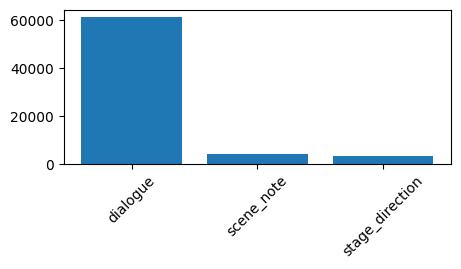

In [37]:
# types of lines without content
counts = df_script["type"].value_counts().head(20)

plt.figure(figsize=(5,2))
plt.bar(counts.index, counts.values)
plt.xticks(rotation=45);

In [38]:
df_script[df_script["type"] == "scene_note"]["scene_note_only"].head(10)

0      Scene: Central Perk, Chandler, Joey, Phoebe, a...
9                                             Time Lapse
20                         Time Lapse, Ross has entered.
74      Time Lapse, Rachel is breating into a paper bag.
122     Scene: The Subway, Phoebe is singing for change.
124    Scene: Ross's Apartment, the guys are there as...
144     Scene: A Restaurant, Monica and Paul are eating.
155    Scene: Ross's Apartment; Ross is pacing while ...
179    Scene: Monica's Apartment, Rachel is watching ...
182    Scene: Ross's Apartment, they're all sitting a...
Name: scene_note_only, dtype: object

In [39]:
df_script[df_script["type"] == "stage_direction"]["stage_direction_only"].head(10)

5                               They all stare, bemused.
43                            Ross gestures his consent.
46     Rachel enters in a wet wedding dress and start...
54     They go to hug but Ross's umbrella opens.  He ...
63     The scene on TV has changed to show two women,...
68     She is pushed down the stairs and everyone che...
83          The door buzzer sounds and Chandler gets it.
100           There's a knock on the door and it's Paul.
108                               Monica goes to change.
126    Joey and Chandler are finishing assembling the...
Name: stage_direction_only, dtype: object

<div class="alert alert-block alert-info">
    Keeping or deleting these rows/columns still needs to be discussed. Research is needed to look into how valuable they would     be for our NLP approaches.
</div>

### "speaker"

Some "speaker" values come with stage directions (AMY COMING OUT OF THE BATHROOM; JOEY (TO ROSS)) or include multiple speakers (PHOEBE, ROSS, CHANDLER, AND JOEY). Some are also unnamed characters (AIR STEWARDESS, PASSENGER #2). Some are nicknames (RACH for RACHEL).

The first needs to move to `stage_direction_inline`. The second and third can be left as is. The fourth will manually be changed.

In [40]:
# a print unique list to see what problems need to be dealt with via regex
# print(df_script["speaker"].dropna().unique())

First we remove some mislabelled rows. Then we start preprocessing and correcting the `speaker` names.

In [41]:
# fix random speaker = SCENE line
mask = df_script["speaker"] == "CREDITS [SCENE"
temp_cols = ["speaker", "scene_note_only", "type", "dialogue_raw", "dialogue_clean"]

df_script.loc[mask, temp_cols] = [
    np.nan,
    "Scene: Central Perk, Russ enters, Chandler and Phoebe are sitting on the couch.",
    "scene_note",
    np.nan,
    np.nan
]

In [42]:
# fix random speaker = CUT TO line
mask2 = df_script["speaker"] == "CUT TO"

df_script.loc[mask2, temp_cols] = [
    np.nan,
    "Scene: Monica and Chandler's apartment.",
    "scene_note",
    np.nan,
    np.nan
]

In [43]:
# drop wrong row with writer's note
df_script = df_script[~(df_script["speaker"] == "NOTE")].copy()

In [44]:
df3 = df_script.copy()
pattern = re.compile(r"^(.*?)\s*(?:[\(\[](.*?)[\)\]])?$")

# Extract name and extra info
df3[["speaker", 'stage_direction_inline']] = df3["speaker"].str.extract(pattern)

In [45]:
# fix few random speakers with actions
subset_lines = [
    'JOEY NODS',
    'RACHEL TO EMMA',
    'WOMAN AT DOOR',
    'ROSS AND RACHEL WHILE LOOKING AT EACH OTHER SURPRISED AND SHOCKED',
    'WOMAN AT DOOR IN A SING SONG VOICE',
    'ROSS WITH A LOOK OF WONDERING HOW LONG THIS IS GOING TO GO ON ON HIS FACE',
    "ROSS STARTS TALKING OVER HER 'DO YOU REMEMBER' LINE",
    'AMY WITH STRAIGHT HAIR',
    'AMY STORMS OUT',
    'RACHEL OPENS THEIR DOOR',
    'JOEY LAUGHS',
    'JOEY LOOKS REJECTED',
    'ROSS TO MONICA',
    'MONICA TO ROSS',
    'MONICA TO EMMA',
    'MONICA TO AMY',
    'AMY WITH CONFUSED LOOK ON FACE',
    'PHOEBE SHAKES HER HAND AND SAYS',
    'PHOEBE LOOKS DOWN',
    'AMY COMING OUT OF THE BATHROOM',
    "ROSS FIRST HAS A LOOK OF 'HUH' THEN CHANGES IT TO SARCASTIC HAPPY",
    'AMY TURNS AROUND TO PHOEBE',
    'AMY TURNS TO ROSS AND RACHEL',
    'ROSS STARTS PLAYING WITH A PLATE',
    'MONICA ABOUT TO HAVE A HEART ATTACK',
    'JOEY RAISES HIS HAND',
    'ROSS LOOKS DOWN',
    'PHOEBE WHILE CUTTING A SWEET POTATOE IN THE AIR',
    'JOEY GROANS AND GETS OFF THE PHONE',
    'JOEY ALL NERVOUS AND LOOKING DOWN AND FIDDLING WITH HIS EAR',
    'AMY WALKS OVER TO THE COUCH AND SITS DOWN NEXT TO RACHEL',
    'RACHEL TURNS TO ROSS',
    'ROSS WALKS OVER',
    'MONICA SCREAMING AT ROSS',
    "RACHEL STARTS MESSING UP AMY'S HAIR",
    'MONICA STARTS CRYING',
    'AMY STARTING TO CRY'
]

pattern2 = re.compile(r"^([A-Z]+(?: (?:AND|AT) [A-Z]+)*)\s*(.*)$")
mask3 = df3['speaker'].isin(subset_lines)

# Apply regex only on the subset of lines
df3.loc[mask3, ['speaker', 'stage_direction_inline']] = df3.loc[mask3, 'speaker'].str.extract(pattern2)

In [46]:
speaker_corrections = {
    "CHAN": "CHANDLER",
    "RACH": "RACHEL",
    "RACEL": "RACHEL",
    "RAHCEL": "RACHEL",
    "RAHCEL": "RACHEL",
    "PHOE": "PHOEBE",
    "MNCA": "MONICA",
    "MONA": "MONICA",
    "MICH": "MICHAEL",
    "PHOE/MNCA": "PHOEBE, MONICA",
    "RTST": "MR. RASTATTER",
    "JOEY/CHAN": "JOEY, CHANDLER",
    "CHAN, JOEY, ROSS": "CHANDLER, JOEY, ROSS",
    "GANG": "ALL",
    "FBOB": "FUN BOBBY",
    "ESTL": "ESTELLE",
    "DR. REMORE": "DR. RAMORAY",
    "DR. DRAKE REMORAY": "DR. RAMORAY",
    "DR. DRAKE RAMORAY": "DR. RAMORAY",
    "DR HORTON": "DR. HORTON",
    "AMGER": "AMBER",
    "EVERYONE": "ALL",
    "DR GREEN": "DR. GREEN",
    "SHERMAN WHITFIELD": "WHITFIELD",
    "MATRESS KING": "MATTRESS KING",
    "BILLY CRYSTAL": "BILLY",
    "ELIZABETH HORNSWOGGLE": "ELIZABETH",
    "DR. TIMOTHY BURKE": "TIM",
    "EVERYONE ALMOST SIMULTANEOUSLY EXCEPT ROSS": "ALL",
    "SANDY/GRUMPUS": "SANDY",
    "JOEY/WIGGLEMUNCH": "JOEY",
    "EVERYONE BUT MONICA": "ALL",
    "EVERYONE THERE SAYS": "ALL",
    "EVERYBODY": "ALL",
    "RACHEL/ACTRESS": "RACHEL",
    "RACHEL/ROSS": "RACHEL, ROSS",
    "PROFESSOR SHERMAN": "PROF. SHERMAN",
    "AMY AND RACHEL AT SAME TIME": "RACHEL, AMY",
    "JOEY'S VOICE, BUT SHE SEES ROSS": "JOEY, ROSS",
    "JOEY'S VOICE/ROSS": "JOEY, ROSS",
    "AGENCY GUY": "ADOPTION AGENCY GUY",
    "DONNY OSMOND": "DONNY",
    "PHOEBE SR": "PHOEBE SR.",
    "MAITRE D�": "MAITRE D'",
    "MATIRE'D": "MAITRE D'",
    "JOEY/DRAKE": "JOEY",
    "ACTRESS/OLIVIA": "OLIVIA",
    "GUYS": "THE GUYS"
}

# replace/map
df3["speaker"] = df3["speaker"].replace(speaker_corrections)

# change " AND " or " & " to ", "
df3["speaker"] = df3["speaker"].str.replace(r"\W\s+AND\s+| \& |\/", ", ", regex=True)
df3["speaker"] = df3["speaker"].str.replace(r"\s+AND\s+", ", ", regex=True)

In [47]:
print("There are at most", len(df3["speaker"].dropna().unique())," speakers in the series, including different combinations of speakers.")

There are at most 777  speakers in the series, including different combinations of speakers.


In [48]:
df_script["speaker"] = df3["speaker"].copy()

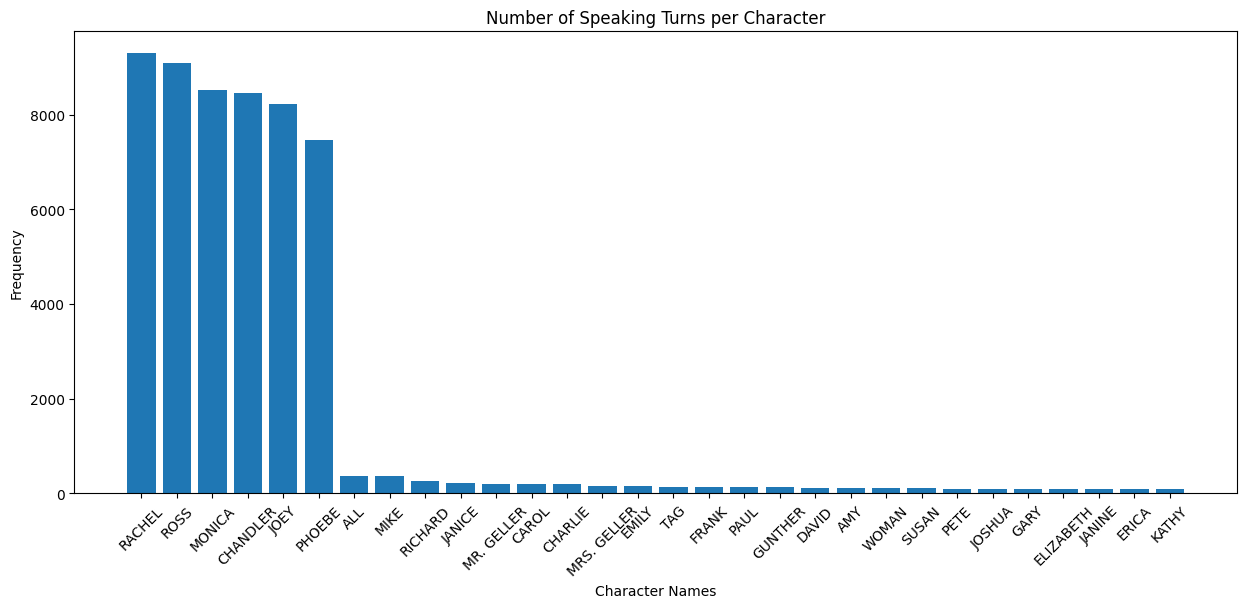

In [49]:
# Count each speaker's speaking turn (not related to number of words or screen time)
counts = df_script["speaker"].value_counts().head(30)

plt.figure(figsize=(15,6))
plt.title("Number of Speaking Turns per Character")
plt.xlabel("Character Names")
plt.ylabel("Frequency")
plt.bar(counts.index, counts.values)
plt.xticks(rotation=45);

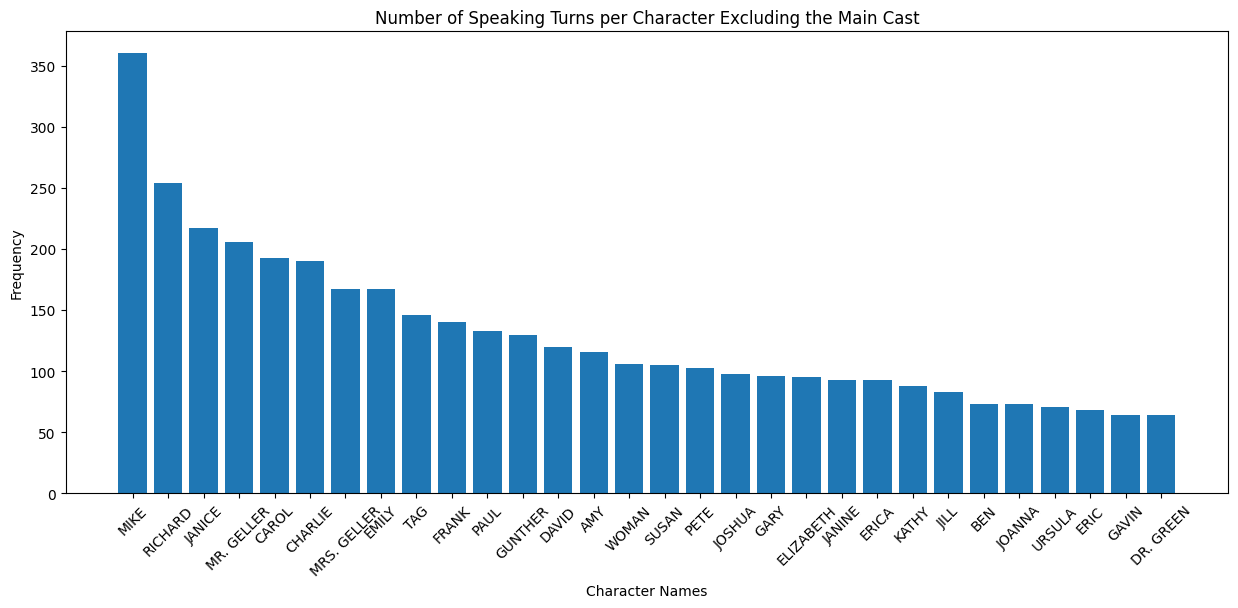

In [50]:
# Count each speaker's speaking turn (without the main cast and "ALL")
counts = df_script["speaker"].value_counts()[7:37]

plt.figure(figsize=(15,6))
plt.title("Number of Speaking Turns per Character Excluding the Main Cast")
plt.xlabel("Character Names")
plt.ylabel("Frequency")
plt.bar(counts.index, counts.values)
plt.xticks(rotation=45);

<div class="alert alert-block alert-info">
    This does not preprocess "BOTH", "ALL", or multiple names divided by commas in different orders. 
    To solve "BOTH" and "ALL" would require manually analyzing the script.
    <br><br>
    A possible solution for this is to split each row where multiple characters speak and duplicate the text. 
    We could then also add a <code>scene_note_inline</code> that the line is said in unison. <b>Ultimately, we will ignore this issue due to time and possibly list it as a limitation.</b>
</div>

### "dialogue_raw", "dialogue_clean", "stage_direction_inline", "scene_note_inline", "stage_direction_only"

Clean unidentifiable characters: �. They seem to be apostrophes. Also look at missingness.

In [51]:
df_script["dialogue_raw"] = df_script["dialogue_raw"].str.replace(r"�", "\'", regex=True)
df_script["dialogue_clean"] = df_script["dialogue_clean"].str.replace(r"�", "\'", regex=True)
df_script["scene_note_inline"] = df_script["scene_note_inline"].str.replace(r"�", "\'", regex=True)
df_script["stage_direction_inline"] = df_script["stage_direction_inline"].str.replace(r"�", "\'", regex=True)

In [52]:
# stage_direction_inline for emotions
print("Missingness percentage for stage_direction_inline:", 
      df_script["stage_direction_inline"].isnull().sum(axis = 0) / df_script.shape[0])

Missingness percentage for stage_direction_inline: 0.8079197250378656


In [53]:
# scene_note_inline for ...something
print("Missingness percentage for scene_note_inline:", 
      df_script["scene_note_inline"].isnull().sum(axis = 0) / df_script.shape[0])

Missingness percentage for scene_note_inline: 0.9915676336945124


In [54]:
# stage_direction_only for ...something again
print("Missingness percentage for stage_direction_only:", 
      df_script["stage_direction_only"].isnull().sum(axis = 0) / df_script.shape[0])

Missingness percentage for stage_direction_only: 0.9519398811604334


### "scene_note_only"
Can be used as an additional attribute to see if the audience prefers certain **locations**. Note that some `stage_direction` columns seem to also have scene locations, but these are too difficult to extract.

In [55]:
print("Missingness percentage:", df_script["scene_note_only"].isnull().sum(axis = 0) / df_script.shape[0], "\n")
print(df_script["scene_note_only"].dropna().unique()[:10])

Missingness percentage: 0.9412210182919725 

['Scene: Central Perk, Chandler, Joey, Phoebe, and Monica are there.'
 'Time Lapse' 'Time Lapse, Ross has entered.'
 'Time Lapse, Rachel is breating into a paper bag.'
 'Scene: The Subway, Phoebe is singing for change.'
 "Scene: Ross's Apartment, the guys are there assembling furniture."
 'Scene: A Restaurant, Monica and Paul are eating.'
 "Scene: Ross's Apartment; Ross is pacing while Joey and Chandler are working on some more furniture."
 "Scene: Monica's Apartment, Rachel is watching Joanne Loves Chaci."
 "Scene: Ross's Apartment, they're all sitting around and talking."]


In [56]:
# extract locations using regex
pattern4 = r"Scene[:,]? ((?:Mr\.|Mrs\.|Dr\.|Ms\. )?[^,.;]+)[.,;]?"

In [57]:
# initial print to find any problems with the regex and fix them
# 595 different unique locations before cleaning
df_script["scene_note_only"].str.extract(pattern4)[0].unique()[:20]

array(['Central Perk', nan, 'The Subway', "Ross's Apartment",
       'A Restaurant', "Monica's Apartment", 'Iridium',
       "Monica and Rachel's", 'Museum of Prehistoric History',
       'Central Park', "Carol's OB/GYN", "Barry's office",
       "Monica and Rachel's apartment", "Chandler and Joey's", 'A street',
       "Chandler's office", 'A Street', 'Cental Perk',
       'Madison Square Garden', 'An Emergency Room'], dtype=object)

In [58]:
# A possible ambiguous entry
# Ms. Geller -- multiple people listed, divided by commas --> "Scene: Ms. Geller, Rachel and Ross storm into the apartment."
df_script[df_script["scene_note_only"].str.contains("Ms. Geller", na=False)]["scene_note_only"].values

array(['Scene: Ms. Geller, Rachel and Ross storm into the apartment.'],
      dtype=object)

Some manual correction is needed first for an episode that does not have any standard formatting.

In [59]:
# have locations but aren't in the usual format: S02E11
# df_script[(df_script["episode_number"]== "S02E11") & ~df_script["scene_note_only"].isna()]

In [60]:
scene_corrections = {
    "at Ross's. Carol and Susan are picking Ben up" : "Scene: Ross's Apartment. Carol and Susan are picking Ben up.",
    "at Rachel and Monica's": "Scene: Rachel and Monica's apartment.",
    "Monica and Rachel's": "Scene: Monica and Rachel's apartment.",
    "Central Perk": "Scene: Central Perk.",
    "at Monica and Rachel's": "Scene: Monica and Rachel's apartment.",
    "at the wedding": "Scene: A wedding.",
}

df_script["scene_note_only"] = df_script["scene_note_only"].replace(scene_corrections)

<div class="alert alert-block alert-info">
    We will need to check the accuracy of the <code>scene_note_only</code> column, since there seems to be big missingness. 
    <br><br>
    <b>Idea:</b> We can take a sample of 236*0.05 = 12 approximately episodes to watch and note down how many scene change sthere are (scene changes = location changes).
</div>

**Testing** is necessary for the accuracy of this column. Hence we can pull a random sample and manually note down how many scene/location changes there are, and calculate how accurate this attribute is. 

In [61]:
print("List of episodes we need to watch and note down the number of scene changes:")
df_script["episode_number"].dropna().sample(12, random_state=6).tolist()

List of episodes we need to watch and note down the number of scene changes:


['S06E06',
 'S03E11',
 'S08E11',
 'S05E11',
 'S04E10',
 'S04E20',
 'S06E07',
 'S02E13',
 'S09E19',
 'S02E18',
 'S02E23',
 'S10E04']

### Could add later - location extracted.
Now we check the number of scene/location changes per episode.

In [62]:
# create new column in df copy with only the extracted strings
df_test = df_script.copy()

# removes where scene is just "continues" or times - make NaN
df_test.loc[df_test["scene_note_only"].str.contains("Scene: continues, Joey finished everything.", na=False), "scene_note_only"] = [
    np.nan,
]

df_test.loc[df_test["scene_note_only"].str.contains("continued from earlier", na=False), "scene_note_only"] = np.nan
df_test.loc[df_test["scene_note_only"].str.contains("later", na=False), "scene_note_only"] = np.nan
df_test.loc[df_test["scene_note_only"].str.contains("After dinner", na=False), "scene_note_only"] = np.nan
df_test.loc[df_test["scene_note_only"].str.contains("We cut back to the present", na=False), "scene_note_only"] = np.nan
df_test.loc[df_test["scene_note_only"].str.contains("The moment we waited for", na=False), "scene_note_only"] = np.nan
df_test.loc[df_test["scene_note_only"].str.contains("We're back to the present", na=False), "scene_note_only"] = np.nan

In [63]:
df_test["scene_note_extracted"] = df_test["scene_note_only"].str.extract(pattern4)[0]

In [64]:
# check number of scene changes per episode
scene_cuts = df_test.groupby("episode_number")["scene_note_extracted"].count()
scene_cuts[:10]

episode_number
S01E01    12
S01E02    11
S01E03    15
S01E04    16
S01E05    16
S01E06     9
S01E07    21
S01E08    13
S01E09    12
S01E10     8
Name: scene_note_extracted, dtype: int64

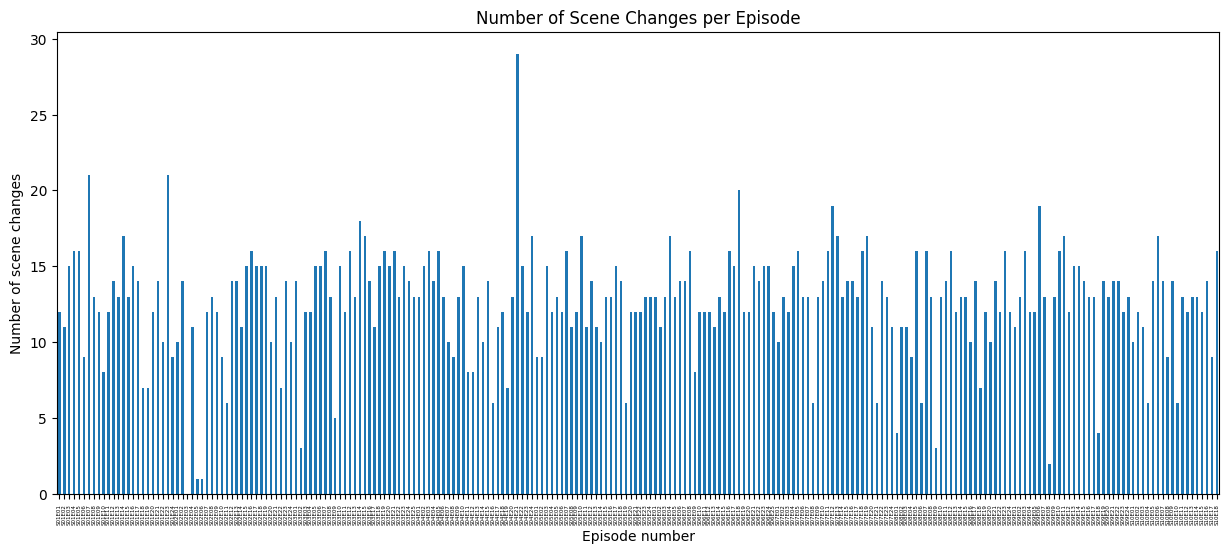

In [65]:
scene_cuts.plot(kind="bar", figsize=(15,6))

plt.xticks(rotation=90, size=4)
plt.xlabel("Episode number")
plt.ylabel("Number of scene changes")
plt.title("Number of Scene Changes per Episode");

`S02E03` seems to have nothing, even upon checking.

In [66]:
scene_cuts_adj = scene_cuts.drop("S02E03") - scene_cuts.loc["S02E03"]
scene_cuts_adj[scene_cuts_adj == scene_cuts_adj.min()]

episode_number
S02E05    1
S02E06    1
Name: scene_note_extracted, dtype: int64

In [67]:
scene_cuts[scene_cuts.values==scene_cuts.max()] # The One with the Invitation, a clip show

episode_number
S04E21    29
Name: scene_note_extracted, dtype: int64

In [68]:
# 2 episodes with only one scene cut each
df_script[df_script["episode_number"].isin(["S02E05", "S02E06"]) & 
          ~df_script["scene_note_only"].isna()]

,episode_number,title,writers,type,speaker,dialogue_raw,dialogue_clean,stage_direction_inline,scene_note_inline,stage_direction_only,scene_note_only,season,episode
7998,S02E05,The One with Five Steaks and an Eggplant,[Chris Brown],scene_note,NaN,NaN,NaN,NaN,NaN,NaN,Scene: At Chandler and Joey's. Ross and Chandl...,2,5
8294,S02E06,The One with the Baby on the Bus,[Betsy Borns],scene_note,NaN,NaN,NaN,NaN,NaN,NaN,Scene: At Monica and Rachel's.,2,6


In [69]:
df_script[df_script["episode_number"].isin(["S02E05", "S02E06"]) & 
          df_script["scene_note_only"].isna()]["stage_direction_only"].dropna().unique()

array(["(MACHINE--JOEY'S VOICE)", "At Monica and Rachel's",
       'At Somplace Nice', 'glasses clinking', "at Monica and Rachel's",
       'phone rings', 'at the concert', 'at Central Perk',
       "Monica's pager goes off", 'Everyone goes over to comfort Monica',
       'Joey lunges for phone and misses.',
       'Chandler has a basketball which he is moving closer to, then away from, Monica',
       'Central Perk',
       'Chandler and Joey are loaded down with baby stuff, and Ben',
       'Monica shakes her head.', 'on the sidewalk outside Central Perk',
       'chez Monica and Rachel', 'Ben starts crying'], dtype=object)

In [70]:
# A few problematic rows, but this can be ignored if we merge all 4 columns anyway.
df_script[~df_script["stage_direction_inline"].isnull() & ~df_script["scene_note_inline"].isnull()]

,episode_number,title,writers,type,speaker,dialogue_raw,dialogue_clean,stage_direction_inline,scene_note_inline,stage_direction_only,scene_note_only,season,episode
34520,S05E23,The One in Vegas: Part 1,"[Andrew Reich, Ted Cohen]",dialogue,JOEY,"Uh, Entertainment Tonight. [Cut to Chandler] Y...","Uh, Entertainment Tonight. Yeah, okay so, goo...",(Hangs up the phone and poses for that picture.),Cut to Chandler,NaN,NaN,5,23
40668,S06E20,The One with Mac and C.H.E.E.S.E.,[Doty Abrams],dialogue,JOEY,"(there's a gunshot on TV) There's my scene, th...","There's my scene, there's my scene. ""Mrs. Wal...",(there's a gunshot on TV) | (Does the smell-th...,Joey on tv,NaN,NaN,6,20
50665,S08E04,The One with the Videotape,[Scott Silveri],dialogue,ROSS,"(voiceover) So when she came in, I got distrac...","So when she came in, I got distracted and tota...",(voiceover),Cut back to the present day.,NaN,NaN,8,4
57728,S09E05,The One with Phoebe's Birthday Dinner,[Scott Silveri],dialogue,ROSS,"No! No, you know what? (closes the door) You [...","No! No, you know what? You , the baby's fine...",(closes the door) | (?) | (?) | (?),can't get in there | I told you a|Tell your,NaN,NaN,9,5


In [71]:
# few corrections for mistakes the regex made
str1 = "In a TV commercial that the gang is watching at Monica and Rachel's"
str2 = "Rachel has gone off on her own to look for the cat's owner"
str3 = "A Street: Monica and Phoebe are walking to a newsstand"
str4 = "Chandler and Joey's Chandler is talking with his mom"
str5 = "A wintry February day in New York City"
str6 = ": Chandler's Office"
str7 = "13: Central Perk"
str8 = "later the bridesmaids and ushers are getting ready to start"
str9 = "Monica and Rachel's: everyone is there and they are watching an info-mercial that stars Joey"

df_test.loc[df_test["scene_note_extracted"] == "The Mr", "scene_note_extracted"] = "The Mr. Bowmont"
df_test.loc[df_test["scene_note_extracted"] == "N", "scene_note_extracted"] = "N.Y.U."
df_test.loc[df_test["scene_note_extracted"] == str1, "scene_note_extracted"] = "Monica and Rachel's apartment"
df_test.loc[df_test["scene_note_extracted"] == str2, "scene_note_extracted"] = np.nan
df_test.loc[df_test["scene_note_extracted"] == str3, "scene_note_extracted"] = "A street"
df_test.loc[df_test["scene_note_extracted"] == str4, "scene_note_extracted"] = "Chandler and Joey's apartment"
df_test.loc[df_test["scene_note_extracted"] == str5, "scene_note_extracted"] = "Central Perk"
df_test.loc[df_test["scene_note_extracted"] == str6, "scene_note_extracted"] = "Chandler's Office"
df_test.loc[df_test["scene_note_extracted"] == str7, "scene_note_extracted"] = "Central Perk"
df_test.loc[df_test["scene_note_extracted"] == str8, "scene_note_extracted"] = "A wedding"
df_test.loc[df_test["scene_note_extracted"] == str9, "scene_note_extracted"] = "Monica and Rachel's apartment"

<div class="alert alert-block alert-info">
    We are missing additional scene cuts as some of them are in <code>stage_direction_only</code> but are too difficult to extract using regex (i.e. S02E05, S02E06). Some of them also don't exist (S02E03). These placements make sense since, when looking at how script writers write scripts, the place they add these notes are based on feeling. When looking at the columns <code>stage_direction_inline</code>, <code>stage_direction_only</code>, <code>scene_note_inline</code>, and <code>scene_note_only</code> side-by-side, there also appears to be some overlap.
</div>

### Continue with location

We aggregate/group the locations to allow for fewer columns. Categories include:

**Central Perk:** 
- Everything around or inside the cafe.
 
**Main apartments:**
- The six friends' main apartments.

**Social life:**
- other restaurants, cafés, bars, diners
- celebrations (parties and weddings, The Rehearsal dinner hall)
- entertainment (zoos, parks, sports games, strip club, museums)
- classes (Lamaze class, Tap Class)

**Other Lodging:**
- other people's apartments
- family houses and apartments
- hotels (incl. hotel rooms and bathrooms and the cabin)

**Transport:**
- airports and flights
- the subway and the subway station
- cars and taxi's

**Public and city spaces:**
- streets, parks, cemetary
- banks and ATMs
- shops and stores (laundromats and dry cleaners)
- gym and its locker room
- beach (incl. beach house)

**Jobs:**
- jobs (incl. job offices and auditions for Joey)
- univeristy (labs, lectures, N.Y.U., where Ross teaches)

**Hospitals:**
- hospital visits
- doctor's offices
- different locations in the hospital.

In [72]:
# Map locations to categories
category_dict = {
    "Central Perk": [
        "Central Perk", "Central Park", "Outside Central Perk", "Central Perk close to closing",
        "inside Central Perk", "Phoebe is in central-perk with Joey telling him what Ross said t her at the beginning",
        "The street outside Central Perk", "Central perk", "Inside Central Perk", "Back in New York",
        "Ross is in Central Perk", "Monica enters Central Perk", "Phoebe is at Central Perk", "Ross walks into Central Perk",
        "Central Perk - Chandler", "The street down the block from Central Perk", "Cental Perk", "Central Perk: Rachel",
        "The street right in front of Central Perk", "Outside of Central Perk", "Outside Central Perk",
        "The street in front of Central Perk", "Phoebe and Rachel sitting on the couch in Central Perk"
    ],

    "Transport": [
        "The Subway", "The subway", "Subway station", "The Porsche",
        "Back in the cab in front of Phoebe's dad's house", "In Phoebe’s Grandmother’s cab",
        "The train", "A train to Poughkeepsie",
        "Gary's cop car", "The ride along", "the 5th Precinct", "Gary's precinct",
        "The Airport", "Airport", "The airport", "An airport in New York", "An airport in London",
        "The airport ticket counter", "The ticket-counter", "The gate", "The gate at the airport",
        "Boarding the plane", "The Virgin Atlantic flight to London that Rachel is on",
        "Flight 1066 to Athens", "A 747 somewhere over the North Atlantic", "An airplane cabin",
        "An aircraft cabin", "That same plane cabin", "The plane", "The Airport Ticket Counter"
    ],

    "Main apartments": [
        "Ross's Apartment", "Ross' apartment", "Ross's apartment", "Ross's bedroom", "Ross’s bedroom", "The fire escape",
        "Ross’s Kitchen", "Ross’s Bedroom", "Ross’s", "Ross’s apartment", "The roof", "Their Building", "Joey's bedroom",
        "Joey's room: Joey is sitting on his bed reading DooL transcript when Rachel walks in", "Joey’s", 'Joey’s Apartment',
        'Joey’s bedroom', "Looking through Ross's window", "The Roof", "Living room", "Phoebe is sitting with Mike", 
        "Ross's new apartment", "Ross's now empty apartment", "Ross's place", "The guest bedroom", "Phoebe's Apartment",
        "Ross and Rachel's apartment", "Ross and Rachel’s apartment", "outside Phoebe's apartment", "Ross", "Ross and",
        "Ross’s Apartment", "Ross's apartment the next morning", "Joey and", "Joey and Rachel's", "Ross and Rachel's",
        "Ross and Rachel's kitchen", "Back to the living room", "house next to the one the Bings are moving into",
        "Monica's Apartment", "Monica's apartment", "Rachel and Monica's", "Monica’s", "Joey's", "Joey's Apartment",
        "Monica’s bedroom", "Monica’s new kitchen", "Monica and Rachel's", "Monica and Rachel's apartment", "Ross'",
        "Monica and Rachel's Balcony", "Monica's Bedroom", "Monica's bedroom", "Monica and Rachel’s", "Ross and Rachel�s",
        "Monica and Rachels apartment", "At Monica and Rachel's", "Monica and Rachel", "Phoebe's apartment: Phoebe", 
        "Rachel and Monica's apartment", "Back at Monica and Rachel's apartment", "Monica and Rachel’s bathroom",
        "Monica and Chandler's apartment", "Monica and Chandler’s apartment", "Monica and Chandler’s", "Chandler",
        "Monica and Chandler's", "Monica and Chandler’s bedroom", "Monica and Chandler’s bathroom", "Chandler and Monica's",
        "Chandler and Monica's apartement", "Chandler and Monica's apartment", "Chandler and Monica's future house", 
        "Chandler and Monica's new house", "Chandler and Monica’s", "Chandler and Monica’s bathroom", "Monica",
        "Monica and Chandler's kitchen", "Monica and Chandler's room", "Chandler and Joey's erm", "Ross and Rachel’s",
        "Chandler arrives home and Monica's got a video of Sharks ready for Chandler", "Chandler arrives home from work",
        "Chandler is packing the broken china in its box", "Chandler walks into Joey's apartment", "Ross is at Phoebe's",
        "Monica and Chandler's Aparment", "Monica and Chandler's apartement", "Monica and Chandler's Apartement",
        "Monica and Chandler's future house", "Monica and Chandler's new house", "Monica and Chandler's weekend",
        "Monica and Chandler's apartment continued", "Monica and Chandler’s new apartment", "Chandler’s and Monica’s apartment",
        "Monica and Chandler’s bedroom", "Monica and Chandler’s bathroom", "Chandler and Joey's Bathroom", "Ross’s Building",
        "Ross's Apartment: Ross is doing something on his laptop when Chandler walks in", "Ross's Building", "Ross's building",
        "Rachel’s Bedroom", "Rachel’s bedroom", "Chandler and Joey's and Ross's", "Mon and Chan's", 'Mona’s Apartment',
        "Chandler and Joey’s Bathroom: Chandler is watching the duck swim in the bathtub", "Monica and Rachel's erm",
        "Rachel’s Room", "Rachel’s old room", "Rachel’s Old Bedroom", "Gary and Phoebe's apartment", "Ross' apartment ",
        "Outside Monica and Rachel's apartment", 'Outside Ross and Rachel�s', "Phoebe’s", "Rachel and Joey's", "Ross�",
        "Rachel's bedroom", "Rachel's room", "Joey is in Monica and Chandler's future house", 'Monica’s Apartment',
        'Monica’s Bedroom', 'Monica’s apartment', 'Ms. Geller', "The Girls apartment", "Outside the Nursery",
        "Chandler and Joey's", "Chandler and Joey’s", "Chandler and Joey's apartment", "Monica's apartment continued",
        "At Chandler and Joey's", "Chandler's apartment", "Chandler's bedroom", "Monica and Chandler's Apartment",
        "Chandler and Joey are standing by the kitchen entrance", "change back an forth: Monica and Chandler's Apartment",
        "Back in Chandler and Joey's apartment", "Joey's new apartment", "Joey's apartment", "Monica's living room",
        "Joey’s apartment", "Joey and Janine’s apartment", "Joey and Rachel's apartment", "Joey and Rachel’s",
        "Joey and now Rachel's apartment", "Joey and Janine’s new apartment", 'Monica and Joey’s', "Rachel and Joey’s"
        "Chandler’s", "Chandler’s bedroom", "Chandler and Joey’s Bathroom", 'Monica and Chandlers apartment', 
        'Monica and Chandler\'s apartment " continuing action', "Monica and Chandler's bedroom", "Rachel and Joey's apartment",
        "The Storage Room in the basement of Monica and Rachel's building", 'Monica and Phoebe’s', "Rachel is at Monica's",
        "Joey's Bedroom", "Joey’s Bedroom", "Joey's room", "Joey’s room", "Joey's place", "Monica and Rachel's balcony",
        "Phoebe's at her apartment waiting for Mike Ross comes over", "Phoebe's apartment", "Back at Phoebe's",
        "Phoebe's place", "Phoebe’s place", "Phoebe's apartment building", "Outside Ross and Rachel’s", "The Balcony",
        "The building's roof", "Outside Ross and Rachel's", "Outside Phoebe's apartment", "Phoebe’s apartment building", 
        "The Building’s Roof", "The Fire Escape", "The Bings� bedroom", "Chandler’s", "Rachel and Joey’s"
    ],
    
    "Other lodging": [
        "Nana's house", "Nana's Bedroom", "Carol and Susan's apartment", "Carol and Susan's", "The porch", "Michelle's",
        "Phoebe's grandmother's place", "Phoebe’s apartment", "Phoebe’s hospital room", "Phoebe and Rachel’s new apartment", 
        "Phoebe and Rachel's class", "Phoebe and Rachel’s", "Phoebe and Rachel’s sitting", "Danny's apartment",
        "Phoebe's dad's house", "Phoebe’s dad’s house", "A random apartment building", "The hotel", "The Mr. Bowmont",
        "Carol and Susan’s", "Kathy’s apartment", "Ursula’s apartment", "Ursula's apartment", "Green's mansion",
        "Amanda's apartment", "Elizabeth Hornswoggle's apartment", "Elizabeth's apartment", "Garbage room: Mr",
        "Elizabeth’s Dorm Room", "Elizabeth’s apartment", "Doug's house", "Ugly Naked Guy's apartment",
        "The Geller household", "The Gellers' house", "The Geller’s Garage", "Bill and Colleen's apartment",
        "The Geller’s kitchen", "Monica’s childhood bedroom (gym)", "Monica’s Restaurant’s kitchen", 'Phoebe Sr',
        "Monica’s Restaurant", "Monica’s Restaurant’s Kitchen", "Monica’s Restaurant Kitchen", "The apartment in the listing",
        "Richard’s Apartment", "Richard’s apartment", "Richard’s bedroom", "Back in the conference room in Tulsa",
        "Mike's apartment", "Mike's parents house", "Mike's parents building", "Barbados", "Guest room",
        "Mike's parents house again", "Mike's place", "Mike and Phoebe in Phoebe's place", "Hotel Monica",
        "Chandler and Eddie's apartment", "Joey's co-star's apartment", "Westminster Abbey", "Tulsa", "The Midfield Day School",
        "Joey’s sister’s house", "Jason’s apartment", "Pete's apartment", "Dr. Burke's apartment", "Hotel's room",
        "Treeger’s apartment", "Mr. Treeger’s apartment", "Jen's apartment", "The conference room in Tulsa again",
        "The Bing household", "The Bings�", "Bings in bed", "Ross and Emily’s room", "Ross and Rachel’s room", 
        "Ross’s Hotel Room", "Ross’s room", "Chandler’s Hotel Room", "Chandler's hotel room", "game room",
        "Monica and Chandler's hotel room", "Chandler and Joey’s hotel room", "Chandler and Monica's room", 
        "Chandler and Monica's weekend", "Chandlers hotel room", "back in the conference room in Tulsa", "The Hotel",
        "Chandler's hotel room in Tulsa", "A Cabin in the Woods", "Outside of Elizabeth’s dormitory", "the hotel game room",
        "the hotel conference room", "Eric’s Apartment", "Hillary’s apartmen", "Hillary’s apartment", "Hotel's reception", 
        "Outside Ugly Naked Guy's apartment", "Outside Danny's apartment", "Outside Mona’s Apartment", "Atlantic City",
        "The house next door to Chandler and Monica's new house", "The house Monica and Chandler are viewing", 
        "It's an old home movie of the Geller's backyard", "Rachel’s Hospital Room", "Joey and Charlie's room",
        "Joey and Janine's", 'Joey and Janine’s', 'Joey enters his hotel room', 'Joey in his hotel in room in Barbados',
        "Joey is back at Hayley's place after there date", 'Joey is back at Hayleys apartment', "The beach house", 
        "The beachhouse", "Joshua’s parents’ apartment", "Kate’s Apartment", "Mrs. Verhoeven’s Apartment", 'Las Vegas', 
        'Monica’s Hotel Room', 'Moving Shot towards The Waltham House', "London", "London Marriott", "Phoebe and Rachel's",
        "Monica’s childhood bedroom (which has been turned into a gym)", "Max and David's lab", "Pete’s apartment",
        "Sting’s Apartment", "Sarah’s bedroom", "The Geller household kitchen", "The Gellers' kitchen", "The Geller’s Kitchen",
        "Outside Cheryl's apartment", "Outside Phoebe's dad's house", "Outside the beach house", "Outside the bathroom",
        "Paradise Hotel lounge in Barbados", "Paul’s Bedroom", "Paul’s Cabin", "Rachel and Barry’s bedroom", "Ross's room",
        "Rachel's hotel room", "Richard's apartment", "Rachel’s hotel room", "Room 816", "Ross and Carol's", 
        "Ross and Monica’s parent’s garage", "Ross and Rachel's hotel room", "Ross and Rachel's room", "Ross's hotel room",
        "The Adoption Agency in Ohio", "The Atlantis Resort", "Ross goes to see Mike to explain about Phoebe"
    ],

    "Hallways": [
        "The hallway of Monica's building", "The Hallway", "Out in the hall", "The Hall", "The hall", "The hallway",
        "the hallway", "Hallway", "Hallway between the apartments", "The hallway between the apartments",
        "Later on in the hallway between the apartments", "The hallway after the party", "The Hallway Outside Ross’s Apartment",
        "The hallway between the two apartments", "The Hallway Between The Apartments",
        "The hallway of Ross’s building", "The hallway in Ross's building", "The corridor",
        "The Lobby", "The Hotel Lobby", "The lobby of Ross's building", "Ross's building's lobby",
        "The lobby in Ross's building", "Their building's lobby", "hall of the romantic inn in Vermont",
        "The hallway between the bedrooms", "Hallway outside Chandler and Joey's apartment",
        "A hallway", "A hallway in an apartment building", "In the hall", "A Hallway",
        "The hallway and stairs outside Chandler and Monica's apartment", "The Lobby of Chandler and Rachel’s building",
        "A hall on the floor where Chandler works", "A lobby", "the hotel lobby", "The Hall Outside Lydia's Room",
        "The Hallway between the Apartments", "The Hallway between the apartments", "Ross and his date walk into a lobby",
        "Ross walks in the hallway to his apartment and stops in front of his own door"
    ],


    "Jobs": [
        "Museum of Prehistoric History", "Museum of Natural History", "Outside Ralph Lauren building", "N.Y.U.",
        'Elevator at the Ralph Lauren Offices', 'Elevator at the Ralph Lauren offices', "Classroom",
        "The museum planetarium", "The Library", "The library’s Paleontology section", "a NYU lecture hall",
        "Ross’s Classroom", "Ross’s classroom", "Ross’s office", "Ross' office", "A Brown Bird meeting",
        "Rachel’s new job", "Rachel's job interview", "Rachel’s Outer Office", "Rachel’s Office", "The \"Pyramid\" Studio",
        "Rachel’s office", "Rachel's office", "Fortunata Fashions", "In front of Monica's restaurant",
        "A kitchen somewhere", "A kitchen where Phoebe and Monica are finishing up a catering job", "The Auditorium",
        "Back in the kitchen at the funeral", "In the living room at the funeral", "Interview room",
        "Chandler's Office", "Chandler's Office in Tulsa", "Chandler's job", "Monica's restaurant", "Ralph Lauren", 
        "Chandler's new window office", "Chandler's new workplace", "Chandler's office", "Chandler's office building",
        "Chandler's office in Tulsa", "Chandler’s Office", "Chandler’s Office Building", "Chandler’s office",
        "Outside Chandler’s Office", "Outside of Chandler’s office", 'Joey is at the cab driver interview',
        "Phoebe's Massage Parlor", "Phoebe's massage parlour", "Phoebe’s Work", "Phoebe’s office", 
        "Phoebe's cab", "Phoebe’s cab", "Phoebe’s class", "Phoebe and Rachel's class", "Phoebe and Rachel’s class",
        "The Class", "Monica and Phoebe's class", "Monica and Phoebe's", "Filming a scene from the movie",
        "The telemarketing office", "The New School", "A Classroom", "Audition room", "Rachel's new job",
        "The lecture", "A Casting Director’s Office", "The casting director’s office", "Rachel’s New Office",
        "Casting Director #1’s office", "Casting Director #2’s office", "Casting Director #3’s office",
        "Joey's audition", "Joey's dance audition", "Joey’s Premiere", "Joey’s work", "Rachel’s outer office",
        "Joey work", "Joey's job", "Unitel Video", "The Set", "The Movie Set", "At a writer's desk", "Recording studio",
        "Days Of Our Lives set", "Days of Our Lives' Studios", "DOOL set", "Joey’s Dressing Room", "Joey’s Audition",
        "Joey and Ben's audition", "Ben and Joey's callback", "Inside Joey’s Premiere", "A Film Set",
        "The theatre where Joey is auditioning", "The next time at the movie set", "The movie set", "Backstage at Joey’s play",
        "Ben and Joey's (Isn't that an ice cream??) callback", "Ben's audition", "Cole-Geddes Casting Agency", "At Pyramid",
        "Joey's at the game show \"Pyramid\" with host Donny Osmond", "The Telethon", "Phoebe's class",
        "The Museum of Prehistoric History (Ross's work)", "Phoebe's Massage Parlor", "Pier 59 Studios",
        "Silvercup Studios", "Silvercup studios", "Barry's office", "Barry's Office", "Mr. Ratstatter's (RTST) office", 
        "Mr. Ratstatter's office",
        "Mr. Zelner's office", "Mr. Zelner’s Office", "Mr. Zellner's office", "An Office Building", "Benjamin's office",
        "Estelle Leonard Talent Agency", "Estelle Leonard Theatrical Agency", "Phoebe’s Herbal Guy’s office", 
        "Terry’s office", "Mac’s Office", "The Portrait Studio", "A Portrait Studio", "Zack's office",
        "The Boardroom", "Ms. McKenna’s Office", "Earl’s Office", "The Freeman Building", "Game room", "Conference room",
        "Joanna’s office", "Estelle’s (Joey’s Agent) Office", "Ross’s lawyer’s office", "A Boardroom", "Pete’s office",
        "Estelle's (Joey's Agent) Office", "Guru Saj’s office: Joey and Chandler have taken the duck to see the guru",
        "The Days of Our Lives producer’s office", "Prof", "Professor Sherman's office", 
    ],

    "Hospitals": [
        "Carol's OB/GYN", "An Emergency Room", "The Emergency Room", "The Hospital", "Hospital", "The hospital",
        "The Coma Guy's Room", "Carol's Hospital Room", "The Waiting Room", "Another Waiting Room", "A hallway in the hospital",
        "Joey and Lydia in the hospital room", "Lydia's Hospital Room", "Lydia's Room", "Carol's room", "The waiting room",
        "Carol's Room", "The Delivery Room", "The Semi-Private Labor Room", "The Recovery Room", "doctor's waiting room",
        "Another Hospital Room", "Another hospital room", "A hospital", "A hospital hallway", "An Empty Hospital Room",
        "Rachel’s Hospital Room", "A doctor’s office", "The Doctor’s Office", "Doctor Connelly's office", "The Broom Closet",
        "The Janitor’s Closet", "The Doctor’s office", "Outside the Janitor’s Closet", "Rachel’s Doctor’s Office",
        "Pediatrician's office", "Dr. Long’s Office", "The Fertility Clinic", "A Janitorial Closet", 'Dr. Burke’s office', 
        "Dr. Rhodes's Office", "A Medical Research Office", "The Medical Research office", "A Union battlefield hospital",
        "The Western front during World War I", "Dr. Burke's office", "A Doctor's Office", "A Hospital Reception",
        "The delivery room", "The delivery room at the hospital", "Monica's eye doctor's office", "The Vending Machines"
    ],

    "City spaces": [
        "A street", "A Street", "The next morning on the street", "City street", "Street", "The street", "The smoker's balcony",
        "Another street", "The Street", "Street in front of the London Marriott", "The street outside the building",
        "Outside", "Outside Room 816", "A Department Store", "Outside the nursery", "Outside the restaurant", "The Park",
        "Outside Macys", "The desert outside of Las Vegas", "Backstreet", "A Bridal Shop", "A Dry Cleaners", "A Fire House",
        "A counter at a government building", "A curbside newsstand", "A Gym", "A Jewelry Shop", "A Video Store", 
        "A clothes store", "A couch store", "A different spray-on tan center", "A grocery store that Janice shops in",
        "A judge’s chambers", "A locker room", "A mailbox", "A newsstand", "A park in London", "The laundromat",
        "A tennis court somewhere in the city of New York", "ATM vestibule", "At the Beach", "The rest stop", "Beauty salon",
        "Beth Israel Medical Center", "Beatrice Bridal Shop", "The park", "The playground", "The freeway", "The Table Store",
        "Frank's tailor shop", "Grammercy Bistero", "In the store", "The beach", "The Xerox place", "The Women’s Restroom",
        'The Xerox Place', "The New York City Children's Fund building", "The New York City Children's fund", 
        "The Jewelry Store", "The Launderama", "The Laundromat", "The Gym", "The Gift Shop", "Kleinman’s",
        "The New York City Children's fund hallway", "The Park: Phoebe and Rachel are getting ready to go running",
        "Chandler is standing on a street corner waiting for Phoebe in the cab", "The couch store", "The cemetary",
        "Madison Square Garden", "Library", "Mattress King", "The Sleep Clinic", "The Wake", "The Men's room",
        "Monica and Van Damme are walking down the street", "The Morgan Chase Museum", "The Men’s Bathroom",
        "Lara and Jeni’s Massage", "New York City Department of Correction", "The Funeral Home", "The Dry Cleaner’s",
        "The Dry Cleaners", "The Department Store", "The ATM vestibule of a bank", "The Animal Hospital", 
        "The Baby Furniture Store", "Shop", "Tattoo parlor", "Ross and Chandler’s bank", "Chandler’s gym",
        "Ross and Emily’s planned wedding place", "Ross and Rachel are at the playground with Emma"
    ],

    "Social Life": [
        "A wedding", "after the wedding", "Barry and Mindy's wedding", "at Barry and Mindy's reception", "The Banquet Room",
        "The Wedding reception", "Ross’s Wedding", "The Wedding Chapel", "The Reception", "The Reception Hall",
        "The wedding rehearsal dinner", "Wedding rehearsal dinner", "The Rehearsal Dinner", "The Rehearsal dinner hall",
        "The Rehearsal Dinner Hall", "Later that evening at the rehearsal dinner", "A Little White Chapel", "The theater",
        "Cousin Frannie’s Wedding Reception", "The Anniversary Party", "A Strip Club", "A Tap Class", "Caesar's Palace Casino",
        "Phoebe’s birthday", "Ross’s birthday", "Rachel’s birthday", "Monica’s birthday", "A blackjack table", "The Theater",
        "The Arena", "The rugby game", "The Ultimate Fighting Championship", "A women’s self-defense class", "The Theatre",
        "The 2001 Soapie Awards", "College reunion party", "Class of '91 reunion", "At the banquet", "The Wedding Hall",
        "The World Premiere of Over There", "4 Queens Club", "Howard's party", "A nightclub", "At the tanning salon",
        "Joey's at the game show Pyramid", "The game show studio", "Phoebe and Rachel at the Spa", "Baby beauty contest",
        "Phoebe and Rachel at the Spa", "At the Spa", "A beauty parlour", "The Spa Reception", "SPA massage center",
        "SPA massage center", "Lamaze class", "Phoebe's Grandmother's memorial", "Estelle's memorial service", "Kathy’s play",
        "Back at the party in 1987", "A strip club", "Ross’s birthday", "Estelle's memorial service", "A Theatre", "A Theater",
        "The church where Ross and Emily are to be married", "Back at the party in 1987", "The slot machines",
        "Camera fades to one of the band members playing guitar at the wedding", "Chandler in the theater", "The Lamaze class",
        "Downstairs at Danny's party", "the Pharmacist convention", "The craps table", 'The breakfast buffet', 'The casino',
        'The casino bar', 'The casino floor', "Joey’s in the front entrance watching for Rachel", 'Halloween Adventure',
        'Healing Hands', 'Healing Hands Inc', 'Heeling Hands Inc', "Monica's party", "Mr. Geller's birthday party",
        "Mr. Geller's party", "The Craps Table", "The Craps table", "The Cooking Class", "Tap Class", "San Diege Zoo", 
        "San Diego Zoo", "The Charity Event", "Rachel's birthday party", "Rachel's party", "Rehearsal dinner hall", 
        "Camera fades to band", "A Restaurant", "A fancy restaurant", "Fancy restaurant", 
        "The ladies' bathroom at the restaurant", "The fancy restaurant", "The Restaurant", "A Chinese Restaurant", 
        "The Chinese Restaurant", "Hotel's bar", "The bathroom at the restaurant", "The bar", 
        "Mike and Phoebe at a restaurant", "Mike's piano bar", 'Piano bar', "Rift’s Restaurant", "Riff's", "Joe-G's Pizza", 
        "Allesandro’s", "Moondance Diner", "A fancy restraunt (Marcel's)",
        "The Moondance diner", "The Moondance Diner", "The Philly", "A Mexican Restaurant", "A nice restraunt",
        "A restaurant", "Restaurant", "Restraunt", "Iridium Restaurant", "Iridium", "A restaurant in Rome",
        "Bloomingdale’s", "Bloomingdale's", "A Pizza Joint", "A random restaurant", "At the counter", "In front of Macys",
        "Another restaurant", "The restaurant", "Outside the restaurant", "Dot’s Spot", "hotel's bar", "the bar",
        "Pete’s Restaurant’s Kitchen", "Pete’s Restaurant", "Phoebe and Mike at a restaurant", "A bar", "Piano Bar",
        "The restaurant with still just Phoebe and Joey", "Back at the restaurant with Joey and Sarah", "The 50's theme cafe", 
        "Back at the restroom at Marcel's", "Back in the restraunt", "Coffee place", "Delmonico's", "Delmonico's restaurant"
    ],
}

In [73]:
## Check that each location is present in the new dictionary --> needs to give an empty set
# unique values from your dataframe
df_values = set(df_test["scene_note_extracted"].dropna().unique().tolist())

# values you already have in your category_dict
checker = set(val for vals in category_dict.values() for val in vals) 

# what's in dictionary but not in df
df_values - checker

set()

In [74]:
# Flatten into value -> category mapping
value_to_category = {val: cat for cat, vals in category_dict.items() for val in vals}

df_test["location"] = df_test["scene_note_extracted"].map(value_to_category)

In [75]:
# printing to compare extraction and categorization
df_test[["scene_note_only", "scene_note_extracted", "location"]].dropna().head(10)

,scene_note_only,scene_note_extracted,location
0,"Scene: Central Perk, Chandler, Joey, Phoebe, a...",Central Perk,Central Perk
122,"Scene: The Subway, Phoebe is singing for change.",The Subway,Transport
124,"Scene: Ross's Apartment, the guys are there as...",Ross's Apartment,Main apartments
144,"Scene: A Restaurant, Monica and Paul are eating.",A Restaurant,Social Life
155,Scene: Ross's Apartment; Ross is pacing while ...,Ross's Apartment,Main apartments
179,"Scene: Monica's Apartment, Rachel is watching ...",Monica's Apartment,Main apartments
182,"Scene: Ross's Apartment, they're all sitting a...",Ross's Apartment,Main apartments
190,"Scene: Monica's Apartment, Rachel is making co...",Monica's Apartment,Main apartments
237,"Scene: Iridium, Monica is working as Frannie e...",Iridium,Social Life
247,"Scene: Central Perk, everyone but Rachel is th...",Central Perk,Central Perk


location
Main apartments    1357
Central Perk        515
Jobs                256
Social Life         239
Other lodging       216
City spaces         148
Hospitals           109
Hallways             81
Transport            47
Name: count, dtype: int64


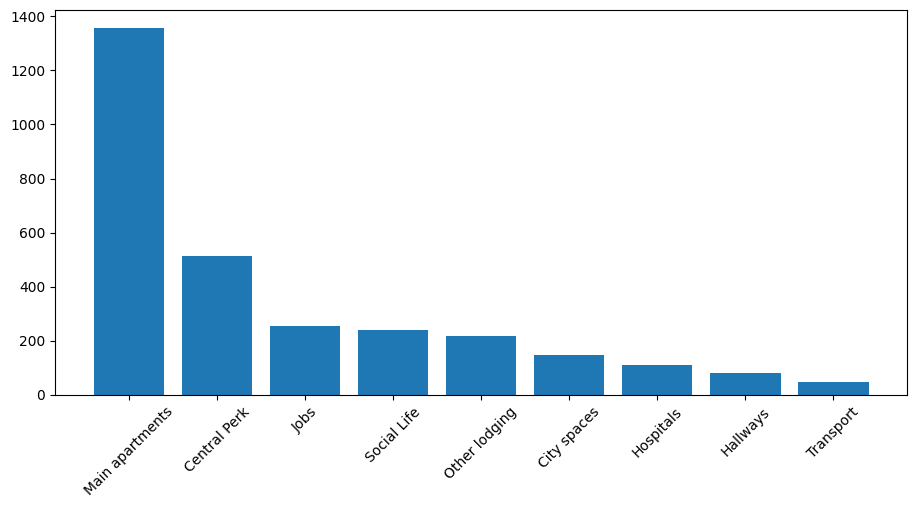

In [76]:
# printing and plotting counts of aggregated locations
counts_loc = df_test["location"].value_counts()
print(counts_loc)

plt.figure(figsize=(11,5))
plt.bar(counts_loc.index, counts_loc.values)
plt.xticks(rotation=45);

---

## Ratings Dataset EDA and Preprocessing

The dataset is from Kaggle, made by users Mohammad Reza Ghari and Moulik Dhade, accessible [here](https://www.kaggle.com/datasets/rezaghari/friends-series-dataset/data). It contains the IMDB ratings of each episode of FRIENDS, along with how many votes there were.

Each row is a new episode. The column names and descriptions are:
- `Year_of_prod` — the year the episode was released
- `Season` — season number
- `Episode Number` — episode number
- `Episode_Title` — Episode title
- `Duration` — duration of the episode in minutes
- `Summary` — long text with a summary of the episode
- `Director` — the director of the specific episode
- `Votes` — Number of ratings/votes in IMDB per episode
- `Stars` — The IMDB star rating

In [77]:
df_rating.columns

Index(['Year_of_prod', 'Season', 'Episode Number', 'Episode_Title', 'Duration',
       'Summary', 'Director', 'Stars', 'Votes'],
      dtype='object')

The number of votes vs IMBD's weighted averages for the ratings could be interesting to cover in the discussion of the report.

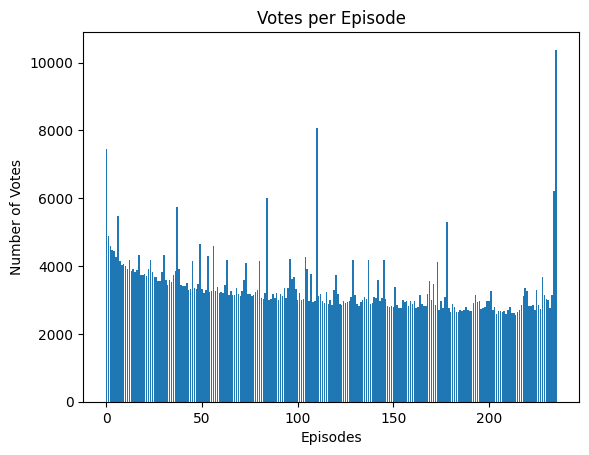

In [78]:
plt.bar(df_rating.index, df_rating["Votes"])
plt.xlabel("Episodes")
plt.ylabel("Number of Votes")
plt.title("Votes per Episode")
plt.show();

In [79]:
# top 5 most voted on episodes
df_rating.sort_values("Votes", ascending=False).head(5)

,Year_of_prod,Season,Episode Number,Episode_Title,Duration,Summary,Director,Stars,Votes
235,2004,10,18,The Last One: Part 2,30,Phoebe races Ross to the airport in a bid to s...,Kevin Bright,9.7,10381
110,1999,5,14,The One Where Everybody Finds Out,22,When Phoebe finds out about Monica and Chandle...,Michael Lembeck,9.7,8066
0,1994,1,1,The One Where Monica Gets a Roommate: The Pilot,22,"Monica and the gang introduce Rachel to the ""r...",James Burrows,8.3,7440
234,2004,10,17,The Last One: Part 1,30,Erica gives birth to the baby that Monica and ...,Kevin Bright,9.5,6221
84,1998,4,12,The One with the Embryos,22,Phoebe's uterus is examined for implantation o...,Kevin Bright,9.5,6006


In [80]:
# top 5 least voted on episodes
df_rating.sort_values("Votes", ascending=False).tail(5)

,Year_of_prod,Season,Episode Number,Episode_Title,Duration,Summary,Director,Stars,Votes
212,2003,9,19,The One with Rachel's Dream,22,Joey is insecure now his Days of Our Lives cha...,Terry Hughes,8.1,2616
213,2003,9,20,The One with the Soap Opera Party,22,Joey throws a cast party on the roof of his bu...,Sheldon Epps,8.2,2615
204,2003,9,11,The One Where Rachel Goes Back to Work,22,Chandler starts looking for a job and is anxio...,Gary Halvorson,8.0,2601
209,2003,9,16,The One with the Boob Job,27,When Monica and Chandler both ask Joey for mon...,Gary Halvorson,8.2,2588
214,2003,9,21,The One with the Fertility Test,22,"Still unable to conceive, Monica and Chandler ...",Gary Halvorson,8.2,2557


In [81]:
# drop unnecessary columns (too little variability: Duration, Votes)
# could drop director / year_of_prod / writers later 
df_rating = df_rating.drop(["Duration", "Votes"], axis="columns")

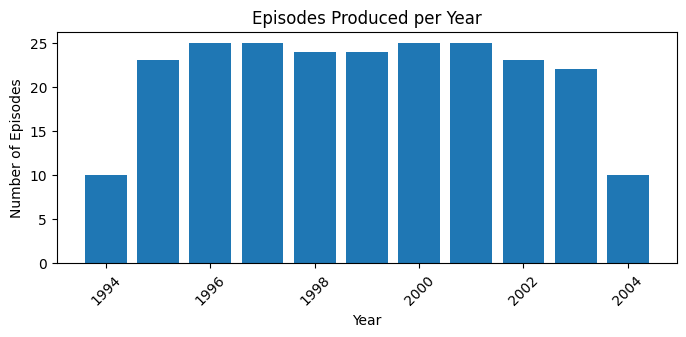

In [82]:
# number of episodes released per year
counts2 = df_rating["Year_of_prod"].value_counts().head(20)

plt.figure(figsize=(8,3))
plt.bar(counts2.index, counts2.values)
plt.xticks(rotation=45)
plt.xlabel("Year")
plt.ylabel("Number of Episodes")
plt.title("Episodes Produced per Year")
plt.show();

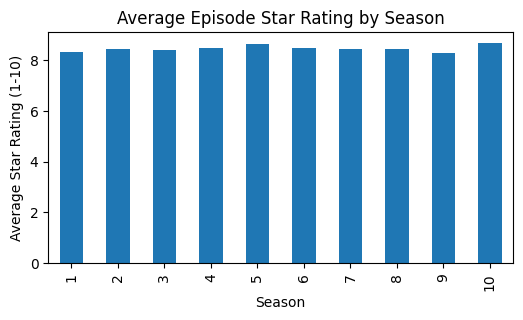

In [83]:
# avg star rating by season
avg_rating = df_rating.groupby("Season")["Stars"].mean()

avg_rating.plot(kind="bar", figsize=(6,3))

plt.xlabel("Season")
plt.ylabel("Average Star Rating (1-10)")
plt.title("Average Episode Star Rating by Season")
plt.show();

In [84]:
# top 5 highest rated episodes
df_rating.sort_values("Stars", ascending=False).head(5)

,Year_of_prod,Season,Episode Number,Episode_Title,Summary,Director,Stars
235,2004,10,18,The Last One: Part 2,Phoebe races Ross to the airport in a bid to s...,Kevin Bright,9.7
110,1999,5,14,The One Where Everybody Finds Out,When Phoebe finds out about Monica and Chandle...,Michael Lembeck,9.7
234,2004,10,17,The Last One: Part 1,Erica gives birth to the baby that Monica and ...,Kevin Bright,9.5
84,1998,4,12,The One with the Embryos,Phoebe's uterus is examined for implantation o...,Kevin Bright,9.5
37,1996,2,14,The One with the Prom Video,The gang watches a home video from the night o...,James Burrows,9.4


In [85]:
# top 5 lowest rated episodes
df_rating.sort_values("Stars", ascending=False).tail(5)

,Year_of_prod,Season,Episode Number,Episode_Title,Summary,Director,Stars
188,2002,8,19,The One with Joey's Interview,Joey prepares for his epic interview with Soap...,Gary Halvorson,7.5
203,2002,9,10,The One with Christmas in Tulsa,"Chandler must spend Christmas in Tulsa, which ...",Kevin Bright,7.5
166,2001,7,21,The One with the Vows,Monica and Chandler are getting married in fou...,Gary Halvorson,7.5
140,2000,6,20,The One with Mac and C.H.E.E.S.E.,Chandler forgets to write down a message for J...,Kevin Bright,7.4
93,1998,4,21,The One with the Invitation,As Ross and Emily send out wedding invitations...,Peter Bonerz,7.2


### Preprocessing

We add the "writers" column from the <code>script</code> dataframe to the <code>rating</code> dataframe. 

In [86]:
## Adding "writers" column to "ratings" df
# grouping, flattening lists if needed/to avoid errors
df_sg = (
    df_script
    .groupby(["season", "episode"])["writers"]
    .agg(lambda x: list(set(sum(x, []))))
    .reset_index()
)

# merge on episode and season info
df_merged = df_rating.merge(df_sg, left_on=["Season", "Episode Number"], right_on=["season", "episode"], how="left")
df_merged = df_merged.drop(columns=["season", "episode"])
df_merged.head()

,Year_of_prod,Season,Episode Number,Episode_Title,Summary,Director,Stars,writers
0,1994,1,1,The One Where Monica Gets a Roommate: The Pilot,"Monica and the gang introduce Rachel to the ""r...",James Burrows,8.3,"[David Crane, Marta Kauffman]"
1,1994,1,2,The One with the Sonogram at the End,Ross finds out his ex-wife is pregnant. Rachel...,James Burrows,8.1,"[David Crane, Marta Kauffman]"
2,1994,1,3,The One with the Thumb,Monica becomes irritated when everyone likes h...,James Burrows,8.2,"[Mike Sikowitz, Jeff Astrof]"
3,1994,1,4,The One with George Stephanopoulos,Joey and Chandler take Ross to a hockey game t...,James Burrows,8.1,[Alexa Junge]
4,1994,1,5,The One with the East German Laundry Detergent,"Eager to spend time with Rachel, Ross pretends...",Pamela Fryman,8.5,"[Jeff Strauss, Jeff Greenstein]"


In [87]:
# remane ratings column names to look nicer
df_merged = df_merged.rename(columns={'Year_of_prod': 'year', 'Season': 'season', 'Episode Number': 'episode', 
                                      'Episode_Title': 'title', 'Summary': 'summary', 'Director': 'director',
                                      'Stars': 'stars'})

In [88]:
df_merged.head(3)

,year,season,episode,title,summary,director,stars,writers
0,1994,1,1,The One Where Monica Gets a Roommate: The Pilot,"Monica and the gang introduce Rachel to the ""r...",James Burrows,8.3,"[David Crane, Marta Kauffman]"
1,1994,1,2,The One with the Sonogram at the End,Ross finds out his ex-wife is pregnant. Rachel...,James Burrows,8.1,"[David Crane, Marta Kauffman]"
2,1994,1,3,The One with the Thumb,Monica becomes irritated when everyone likes h...,James Burrows,8.2,"[Mike Sikowitz, Jeff Astrof]"


We also add location proportions per episode to the <code>rating</code> dataframe.

In [89]:
# Add proportions spent in each location per episode (number of speaking turns)
# to rating df as separate columns

# group by season, episode, and location, and count rows
counts = (
    df_test.groupby(["season", "episode", "location"])
    .size()
    .reset_index(name="count")
)

# get total rows per combo (season, episode)
totals = (
    counts.groupby(["season", "episode"])["count"]
    .transform("sum")
)

counts["proportion"] = counts["count"] / totals

# pivot so each location is its own column
episode_locations = counts.pivot_table(
    index=["season", "episode"],
    columns="location",
    values="proportion",
    fill_value=0
).reset_index()

# flatten column index
episode_locations.columns.name = None
episode_locations.head(5) 

,season,episode,Central Perk,City spaces,Hallways,Hospitals,Jobs,Main apartments,Other lodging,Social Life,Transport
0,1,1,0.250000,0.000000,0.0,0.000000,0.000000,0.500000,0.0,0.166667,0.083333
1,1,2,0.181818,0.000000,0.0,0.272727,0.272727,0.272727,0.0,0.000000,0.000000
2,1,3,0.333333,0.133333,0.0,0.000000,0.066667,0.266667,0.0,0.200000,0.000000
3,1,4,0.187500,0.187500,0.0,0.250000,0.000000,0.375000,0.0,0.000000,0.000000
4,1,5,0.375000,0.187500,0.0,0.000000,0.000000,0.125000,0.0,0.312500,0.000000


In [90]:
# merge 2 datasets
df_rating = pd.merge(
    df_merged,
    episode_locations,
    on=["season", "episode"],  # common keys
    how="inner"  # only keep episodes that appear in both
)

In [91]:
# drop writers, episode_number in df_script and reset the index
df_script = df_script.drop(columns=["writers", "episode_number"]).copy()
df_script.index = range(len(df_script))

# Final Datasets

<div class="alert alert-block alert-success">
    <b>Dataframe descriptions:</b> 
    <br><br>
    <code>df_script</code> contains title, season, episode (all three match the rating df's columns by the same name), along with script info. All speakers are written in all caps. It is possible to add the location of the scenes, when it is known, in an additional column.
    <br><br>
    <code>df_rating</code> has title, season, episode (matching with script df) and summary, director, writers, with IMDB star rating. It also has the proportions for each location per episode as separate columns. This can easily be removed is needed.

</div>

In [92]:
df_script.head(5)

,title,type,speaker,dialogue_raw,dialogue_clean,stage_direction_inline,scene_note_inline,stage_direction_only,scene_note_only,season,episode
0,The One Where Monica Gets a Roommate: The Pilot,scene_note,NaN,NaN,NaN,NaN,NaN,NaN,"Scene: Central Perk, Chandler, Joey, Phoebe, a...",1,1
1,The One Where Monica Gets a Roommate: The Pilot,dialogue,MONICA,There's nothing to tell! He's just some guy I ...,There's nothing to tell! He's just some guy I ...,NaN,NaN,NaN,NaN,1,1
2,The One Where Monica Gets a Roommate: The Pilot,dialogue,JOEY,"C'mon, you're going out with the guy! There's ...","C'mon, you're going out with the guy! There's ...",NaN,NaN,NaN,NaN,1,1
3,The One Where Monica Gets a Roommate: The Pilot,dialogue,CHANDLER,"All right Joey, be nice. So does he have a hu...","All right Joey, be nice. So does he have a hu...",NaN,NaN,NaN,NaN,1,1
4,The One Where Monica Gets a Roommate: The Pilot,dialogue,PHOEBE,"Wait, does he eat chalk?","Wait, does he eat chalk?",NaN,NaN,NaN,NaN,1,1


In [93]:
df_rating.head(5)

,year,season,episode,title,summary,director,stars,writers,Central Perk,City spaces,Hallways,Hospitals,Jobs,Main apartments,Other lodging,Social Life,Transport
0,1994,1,1,The One Where Monica Gets a Roommate: The Pilot,"Monica and the gang introduce Rachel to the ""r...",James Burrows,8.3,"[David Crane, Marta Kauffman]",0.250000,0.000000,0.0,0.000000,0.000000,0.500000,0.0,0.166667,0.083333
1,1994,1,2,The One with the Sonogram at the End,Ross finds out his ex-wife is pregnant. Rachel...,James Burrows,8.1,"[David Crane, Marta Kauffman]",0.181818,0.000000,0.0,0.272727,0.272727,0.272727,0.0,0.000000,0.000000
2,1994,1,3,The One with the Thumb,Monica becomes irritated when everyone likes h...,James Burrows,8.2,"[Mike Sikowitz, Jeff Astrof]",0.333333,0.133333,0.0,0.000000,0.066667,0.266667,0.0,0.200000,0.000000
3,1994,1,4,The One with George Stephanopoulos,Joey and Chandler take Ross to a hockey game t...,James Burrows,8.1,[Alexa Junge],0.187500,0.187500,0.0,0.250000,0.000000,0.375000,0.0,0.000000,0.000000
4,1994,1,5,The One with the East German Laundry Detergent,"Eager to spend time with Rachel, Ross pretends...",Pamela Fryman,8.5,"[Jeff Strauss, Jeff Greenstein]",0.375000,0.187500,0.0,0.000000,0.000000,0.125000,0.0,0.312500,0.000000


## Feature Engineering
We will create the NLP features and attributes, and later look into feature selection